In [2]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import numpy.random as rng
import math
import pandas as pd



# Hyperparameters
my_s1 = 25
my_s2 = 25
var_s1 = 25/3
var_s2 = 25/3
var_t = 25/3

t_guess = 1 #unknown t in mean vector, init guess

# 2D case
my_S = [my_s1, my_s2]
sigma_s = [[var_s1, 0], [0, var_s2]]
sigma_t = var_t

# Samples
num_samples = 10200
s_sample = np.zeros((num_samples, 2))
t_sample = np.zeros(num_samples)

# Task specifik covariance matrix
det_T = 1/((1/var_s1+1/var_t)*(1/var_s2+1/var_t)-1/var_t**2)

# Gibbs Sampler
# Calculate my using corolary 1 

def update_my(t, my_s1, var_s1, my_s2, var_s2, var_t, Sigma_T):
    return Sigma_T@np.array([[my_s1/var_s1 + t/var_t], [my_s2/var_s1 - t/var_t]])

# Gibbs Sampler function
# s_sample and t_ sample are two/one dimentional vectors storing the values calculated 
def gibbs_sample(t_guess, my_s1, var_s1, my_s2, var_s2, var_t, Sigma_T, s_sample, t_sample, y, num_samples):
    my = update_my(t_guess, my_s1, var_s1, my_s2, var_s2, var_t, Sigma_T)
    s_sample[0] = rng.multivariate_normal(my.T[0], sigma_s)
    t_sample[0] = t_guess
    a = -math.inf
    b = 0
    if(y > 0):
        a = 0
        b = math.inf
    for i in range(num_samples):
        #my_t = Sigma_T@np.array([[my_s1/var_s1 + t_sample[i-1]/var_t], [my_s2/var_s1 - t_sample[i-1]/var_t]])
        my = update_my(t_sample[i-1], my_s1, var_s1, my_s2, var_s2, var_t, Sigma_T)
        s_sample[i] = rng.multivariate_normal(my.T[0], Sigma_T)
        t_sample[i] = sp.stats.truncnorm.rvs(a, b, s_sample[i][0]-s_sample[i][1], var_t)

def predict(mean1, std1, mean2, std2):
    num_draw = 9
    res_1 = 0
    res_2 = 0
    for i in range(num_draw):
        if(rng.normal(mean1, std1) - rng.normal(mean2, std2)>0):
            res_1+=1
        else:
            res_2+=1
    if(res_1>res_2):
        return 1
    else:
        return -1

<function matplotlib.pyplot.show(*args, **kw)>

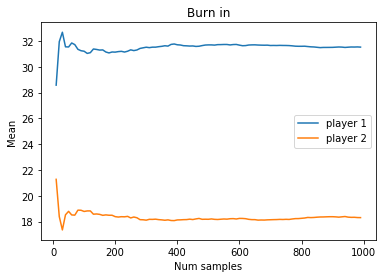

In [39]:
# Task 4 Gibbs and Burn in
###########################

samples = [2200]
Sigma_T = det_T*np.array([[1/var_s2 + 1/var_t, 1/var_t], [1/var_t, 1/var_s1 + 1/var_t]])
for sample in samples:
    s_sample = np.zeros((sample, 2))
    t_sample = np.zeros(sample)
    gibbs_sample(t_guess, my_s1, var_s1, my_s2, var_s2, var_t, Sigma_T, s_sample, t_sample, 1, sample)
    

# Burn in
x = np.linspace(0, 60, 1000)
s1b = []
s2b = []
y = range(10, 1000, 10)
for burn in y:
    s1_spred = np.mean(s_sample[:burn, 0])
    s1_vpred = np.std(s_sample[:burn, 0])
    s2_spred = np.mean(s_sample[:burn, 1])
    s2_vpred = np.std(s_sample[:burn, 1])
    s1b.append(s1_spred)
    s2b.append(s2_spred)

plt.plot(y, s1b, label='player 1')
plt.plot(y, s2b, label='player 2')
plt.xlabel('Num samples')
plt.ylabel('Mean')
plt.title('Burn in')
plt.legend()
plt.show

# Set burnin = 200 from results above


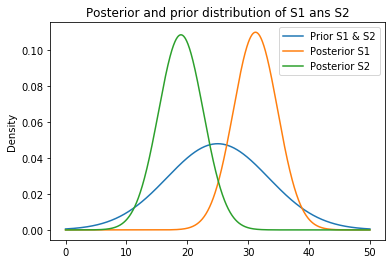

In [27]:
# Compate posteriors with prior

samples = [2200]
burn=200
Sigma_T = det_T*np.array([[1/var_s2 + 1/var_t, 1/var_t], [1/var_t, 1/var_s1 + 1/var_t]])
for sample in samples:
    s_sample = np.zeros((sample, 2))
    t_sample = np.zeros(sample)
    gibbs_sample(t_guess, my_s1, var_s1, my_s2, var_s2, var_t, Sigma_T, s_sample, t_sample, 1, sample)

s1_spred = np.mean(s_sample[:burn, 0])
s1_vpred = np.std(s_sample[:burn, 0])
s2_spred = np.mean(s_sample[:burn, 1])
s2_vpred = np.std(s_sample[:burn, 1])
x = np.linspace(0, 50, 1000)
plt.plot(x, sp.stats.norm.pdf(x, my_s1, var_s1), label='Prior S1 & S2')
plt.plot(x, sp.stats.norm.pdf(x, s1_spred, s1_vpred), label='Posterior S1')
plt.plot(x, sp.stats.norm.pdf(x, s2_spred, s2_vpred), label='Posterior S2')
plt.ylabel('Density')
plt.legend()
plt.title('Posterior and prior distribution of S1 ans S2')
plt.show()

C:\Users\eyste\Anaconda3\envs\probml\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\eyste\Anaconda3\envs\probml\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\eyste\Anaconda3\envs\probml\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

<function matplotlib.pyplot.show(*args, **kw)>

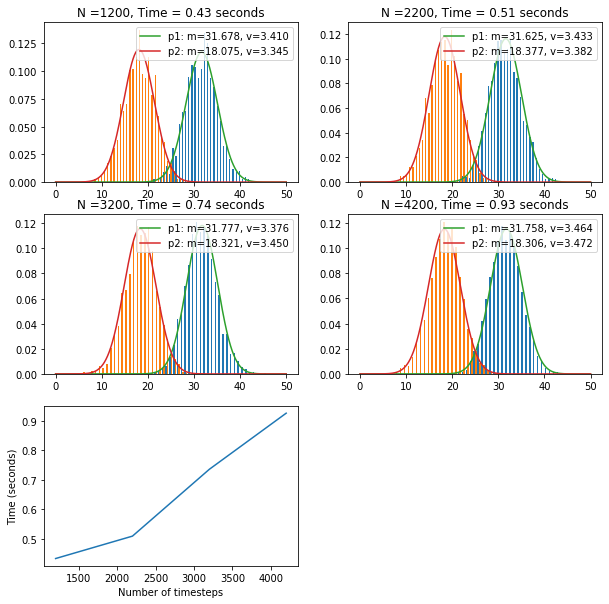

In [8]:
import time
# Computation time vs accuracy
samples = range(1200,5200,1000)
x = np.linspace(0, 50, 1000)
burn = 200
Sigma_T = det_T*np.array([[1/var_s2 + 1/var_t, 1/var_t], [1/var_t, 1/var_s1 + 1/var_t]])
t = []
# Subplot the 4 different number of samples
plt.figure(figsize=(10,10))
for index, sample in enumerate(samples):
    t_start = time.time()
    s_sample = np.zeros((sample, 2))
    t_sample = np.zeros(sample)
    gibbs_sample(t_guess, my_s1, var_s1, my_s2, var_s2, var_t, Sigma_T, s_sample, t_sample, 1, sample)
    
    s1_spred = np.mean(s_sample[burn:, 0])
    s1_vpred = np.std(s_sample[burn:, 0])
    s2_spred = np.mean(s_sample[burn:, 1])
    s2_vpred = np.std(s_sample[burn:, 1])
    
    plt.subplot(3,2,index+1).hist(s_sample[burn:], bins=50, density=True)
    #label=str("%.3f"%s1_spred)+", var:"+"%.3f"%s1_vpred+ " n="+ str(sample)
    plt.subplot(3,2,index+1).plot(x, sp.stats.norm.pdf(x, s1_spred, s1_vpred), label='p1: m='+"%.3f"%s1_spred+', v='+"%.3f"%s1_vpred)
    plt.subplot(3,2,index+1).plot(x, sp.stats.norm.pdf(x, s2_spred, s2_vpred), label='p2: m='+"%.3f"%s2_spred+', v='+"%.3f"%s2_vpred)
    
    plt.subplot(3,2,index+1).legend(loc='upper right')
    end = time.time()-t_start
    t.append(end)
    plt.subplot(3,2,index+1).set_title('N =' + str(sample) + ', Time = ' + "%.2f"%end+" seconds")

# Plot computational time as function of samples
plt.subplot(325).plot(samples, t)
plt.subplot(325).set_xlabel('Number of timesteps')
plt.subplot(325).set_ylabel('Time (seconds)')
plt.show

In [5]:
# Q5 & Q6 Serie A ADF and prediction
#####################################
t_start = time.time()
with open('SerieA.CSV', 'r') as f:
    A = pd.read_csv(f)
print(A)

mean_dict = dict()
std_dict = dict()
r_dict = dict()
i_dict = dict()
start_mean = 25
start_std = 25/3
N = 2200
# Fill dicts with team name and init values
for team in A['team1']:
    if(team not in mean_dict):
        mean_dict[team] = [start_mean]
        std_dict[team] = [start_std]
        r_dict[team] = []
        i_dict[team] = []

    
vart = 25/3
t_g = 5
guess_correct = 0
guess_total = 0
draw = 0
A_rand = A.sample(frac=1).reset_index(drop=True)
#for index, row in A_rand.iterrows():
for index, row in A_rand.iterrows():
    if(index%50 == 0):
        print(index)
    
    result = row['score1']-row['score2']
    r_dict[row['team1']].append(result)
    r_dict[row['team2']].append(-result)
    i_dict[row['team1']].append(index)
    i_dict[row['team2']].append(index)
    if(result==0):
        draw +=1      
    else:
        s_sample1 = np.zeros((N, 2))
        t_sample1 = np.zeros(N)
        my1 = mean_dict[row['team1']][-1]
        my2 = mean_dict[row['team2']][-1]
        std1 = std_dict[row['team1']][-1]
        std2 = std_dict[row['team2']][-1]
        my = [my1, my2]
        var = [[std1, 0], [0, std2]]
        
        # Predict result
        pred = predict(my1, std1, my2, std2)
        if((pred >0 and result>0) or (pred<0 and result<0)):
            guess_correct+=1
        guess_total+=1
        
        det = 1/((1/std1+1/vart)*(1/std2+1/vart)-1/vart**2)
        cov = det*np.array([[1/std2 + 1/vart, 1/vart], [1/vart, 1/std2 + 1/vart]])
        gibbs_sample(t_g, my1, std1, my2, std2, vart, cov, s_sample1, t_sample1, result, N)
        
        b_in = 400

        # Calculate new mean and var, disregard burn-in
        s1spred = np.mean(s_sample1[b_in:, 0])
        s1vpred = np.std(s_sample1[b_in:, 0])
        s2spred = np.mean(s_sample1[b_in:, 1])
        s2vpred = np.std(s_sample1[b_in:, 1])
        # Insert new values in dict
        mean_dict[row['team1']].append(s1spred)
        std_dict[row['team1']].append(s1vpred)
        mean_dict[row['team2']].append(s2spred)
        std_dict[row['team2']].append(s2vpred)
        
print(draw)
print('total time :',time.time()-t_start)

     yyyy-mm-dd  HH:MM       team1     team2  score1  score2
0    2018-08-18  18:00      Chievo  Juventus       2       3
1    2018-08-18  20:30       Lazio    Napoli       1       2
2    2018-08-19  18:00      Torino      Roma       0       1
3    2018-08-19  20:30    Sassuolo     Inter       1       0
4    2018-08-19  20:30       Parma   Udinese       2       2
..          ...    ...         ...       ...     ...     ...
375  2019-05-26  20:30        Roma     Parma       2       1
376  2019-05-26  20:30       Inter    Empoli       2       1
377  2019-05-26  20:30  Fiorentina     Genoa       0       0
378  2019-05-26  20:30    Cagliari   Udinese       1       2
379  2019-05-26  20:30    Atalanta  Sassuolo       3       1

[380 rows x 6 columns]
0
50
100
150
200
250
300
350
108
total time : 332.51905584335327


53.00478995268679
32.41056966800746


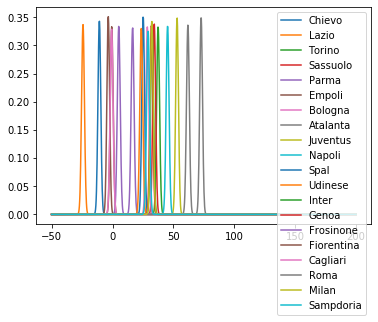

61.907219099176096
pred rate: 0.6029411764705882


In [141]:
print(mean_dict['Juventus'][-1])
print(mean_dict['Inter'][-1])
x = np.linspace(-50, 200, 1000)
for team in mean_dict:
    plt.plot(x, sp.stats.norm.pdf(x, mean_dict[team][-1], std_dict[team][-1]), label=team)
plt.legend()
plt.show()
print(mean_dict['Atalanta'][-1])
print('pred rate:', guess_correct/guess_total)

[25, 41.69594917083808, 45.942376099280835, 43.88831767467889, 29.229011833782028, 28.961170340211385, 29.87238162603256, 31.696003617458192, 33.006975523066814, 33.17943970723534, 34.30952446509314, 29.051875447854318, 29.769808599794132, 28.599708551851897, 30.52438179200255, 26.96088406389154, 27.880801921625043, 28.974118914739577, 29.742398034674032, 30.61900962686981, 29.35924492657688, 28.5147361605777, 29.46954315630517, 30.400165750537013, 29.286583761063373, 28.35536863202905, 27.4441996042403]


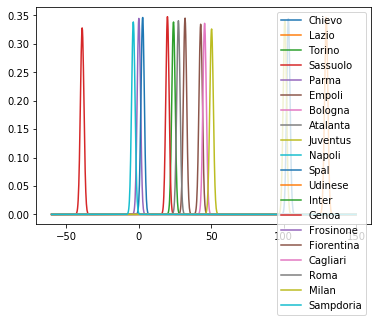

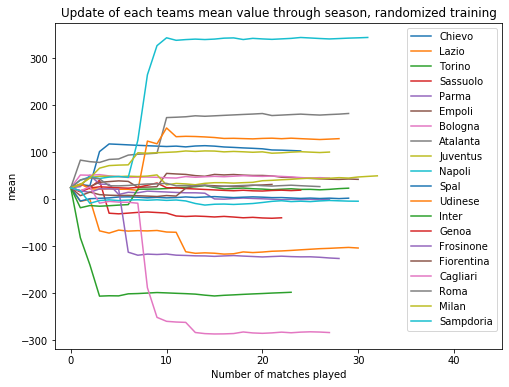

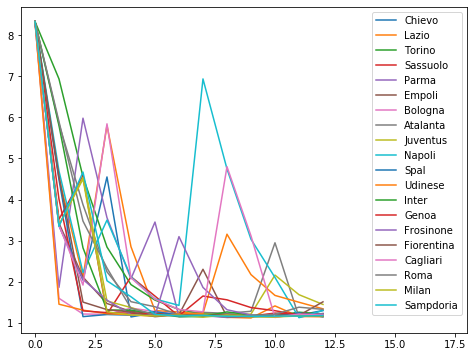

[25, 31.704441425459887, 46.667800280925974, 49.426297462709904, 49.16162175243419, 48.74304786387, 49.64363145814463, 48.90014935277907, 49.819760140112955, 52.300900773664004, 31.066348299306313, 34.112360837037286, 33.14854325133258, 31.323166883507696, 34.39784104775854, 35.74460973522929, 35.741784490366605, 34.826302103892964, 35.781745754074166, 36.54060136140171, 39.8885733848004, 40.73469741669832, 41.95050527526035, 42.941485007024326, 44.36029372749164, 45.29878451151683, 44.404861364477235, 45.171511496773974, 46.45654453429468, 45.560260413464114, 47.87262148412888, 49.14743251094902, 50.32142547591971]
[0, 2, 1, 2, 2, -2, 1, 1, 1, 2, 0, 2, 1, 1, 3, 2, 1, 1, -1, 2, 3, 1, 0, 1, 1, 0, 1, 1, 3, -2, 3, 3, -2, 2, 1, 0, 0, 2]
[1, 2, 7, 24, 102, 107, 109, 111, 124, 134, 155, 162, 167, 171, 172, 179, 192, 207, 213, 227, 249, 255, 259, 275, 279, 292, 293, 298, 303, 312, 324, 330, 335, 341, 342, 346, 364, 366]
[0, 3, 1, 0, 1, 1, 0, -2, 3, 0, 2, 0, 0, 3, 1, 0, 1, 0, -1, 2, 1, 2, -3, 

In [7]:
print(mean_dict['Roma'])
x = np.linspace(-60, 150, 1000)
for team in mean_dict:
    plt.plot(x, sp.stats.norm.pdf(x, mean_dict[team][-1], std_dict[team][-1]), label=team)
plt.legend()
plt.show()
x = np.linspace(-60, 150, 1000)
chosen = ['Juventus', 'Roma', 'Napoli', 'Atalanta']
chosen = ['Juventus', 'Spal', 'Sampdoria']
plt.figure(figsize=(8,6))
for team in mean_dict:
    plt.plot(mean_dict[team], label=team)
plt.title('Update of each teams mean value through season, randomized training')
plt.xlabel('Number of matches played')
plt.ylabel('mean')
plt.xlim(right=45)
plt.legend()
plt.show()
plt.figure(figsize=(8,6))
for team in mean_dict:
    plt.plot(std_dict[team][:13], label=team)
    plt.xlim(right=12)
plt.xlim(right = 18)
plt.legend()
plt.show()
print(mean_dict['Juventus'])
print(r_dict['Juventus'])
print(i_dict['Juventus'])
print(r_dict['Roma'])
print(i_dict['Roma'])